---
title: Enformer usage neanderthal - jupyter notebook version
date: '2025-04-28'
description: predict neanderthal epigenome with enformer
jupyter: 
  kernelspec:
    name: "conda-env-enformer46100-py"
    language: "python"
    display_name: "enformer46100"
eval: false
freeze: true
categories:
  - gene46100
  - notebook
---

> modified from Enformer usage notebook in https://github.com/google-deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb





### Highly recommended: create a new conda environment

If you install the tensorflow and other packages needed for this notebook, it will downgrade numpy and probably other packages and stop working for other notebooks. I strongly recommend to clone the gene46100 conda environment and install the python packages as needed. 

```
conda create --name newenv46100 --clone oldenv46100
```



### Steps

This notebook demonstrates how to
- Make predictions with Enformer using human reference
- Make predictions using Neanderthal vcf

## 1. set up and function definitions
This is Sabrina's EnformerVCF.py file with functions necessary to run vcf modified enformer, based on functions from Temi and Sai, in turn based on Avsec et al's code


### Install Required Python Packages (First Run Only)

In [ ]:
# Install Required Python Packages (First Run Only)
first_time = False  # Set to False after first run

if first_time:
    %pip install tensorflow
    ## this requires  numpy<2.2.0,>=1.26.0 (from tensorflow)
    ## it will uninstall numpy not compatible with tensorflow

    import platform
    if platform.processor() == 'arm':
        print("Apple Silicon detected, installing tensorflow-metal...")
        %pip install tensorflow-metal
    else:
        print("Not running on Apple Silicon, skipping tensorflow-metal installation")

    %pip install tensorflow_hub
    # %pip install joblib # already installed
    %pip install kipoiseq
    # %pip install pyfaidx # already installed
    # %pip install pandas # already installed
    # %pip install numpy # already installed
    # %pip install matplotlib # already installed
    # %pip install seaborn # already installed
    %pip install cyvcf2

    %pip install Bio

### Import Libraries and Define Utility Functions

In [1]:
# Import Libraries and Define Utility Functions
import tensorflow as tf

# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import tensorflow_hub as hub # for interacting with saved models and tensorflow hub
import joblib
import gzip # for manipulating compressed files
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import pyfaidx # to index our reference genome file
import pandas as pd # for manipulating dataframes
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for plotting
import seaborn as sns # for plotting
import pickle # for saving large objects
import os, sys # functions for interacting with the operating system
import cyvcf2

import Bio
from Bio.Seq import Seq
def create_rev_complement(dna_string):
    return(str(Seq(dna_string).reverse_complement()))

import io
import os
import gzip

Num GPUs Available:  1


### Define Enformer Model Classes and Sequence Extraction

In [2]:
# Define Enformer Model Classes and Sequence Extraction

SEQUENCE_LENGTH = 393216


class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)
  
class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)

class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)

class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]

# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    #import pd.Interval as Interval
    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()

### Data Processing and Visualization Functions

In [3]:
# Data Processing and Visualization Functions
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)

# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

def read_vcf(path):
    with gzip.open(path, 'rt') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

# def vcf_to_seq(target_interval, individual, vcf, fasta_extractor):
#   ## should be replaced with vcf_to_seq_faster
#   target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))
#   window_coords = target_interval.resize(SEQUENCE_LENGTH)
#       # two haplotypes per individual
#   haplo_1 = list(target_fa[:])
#   haplo_2 = list(target_fa[:])

#   ref_mismatch_count = 0
#   for i,row in vcf.iterrows():
#     geno = row[individual].split("|")
#     if (row["POS"]-window_coords.start-1) >= len(haplo_2):
#       continue
#     if (row["POS"]-window_coords.start-1) < 0:
#       continue
#     if geno[0] == "1":
#       haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
#     if geno[1] == "1":
#       haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]
#   return haplo_1, haplo_2

def vcf_to_seq_faster(target_interval, individual, vcf_file, fasta_extractor):
  # target_inverval is a kipoiseq interval, e.g. kipoiseq.Interval("chr22", 18118779, 18145669)
  # individual is the id of the individual in the vcf file
  
  target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))
  window_coords = target_interval.resize(SEQUENCE_LENGTH)
      # two haplotypes per individual
  haplo_1 = list(target_fa[:])
  haplo_2 = list(target_fa[:])

  # Open the VCF file
  vcf_reader = cyvcf2.VCF(vcf_file)

  # Specific genomic region
  CHROM = window_coords.chrom
  START = max(1,window_coords.start)
  END = min(window_coords.end, fasta_extractor._chromosome_sizes[CHROM]-1)

  count1 = 0
  count2 = 0

  # Iterate through variants in the specified region
  for variant in vcf_reader(CHROM + ':' + str(START) + '-' + str(END)):
      # Access the individual's genotype using index (0-based) of the sample
      individual_index = vcf_reader.samples.index(individual)
      genotype = variant.genotypes[individual_index]
      ALT=variant.ALT[0]
      REF=variant.REF
      POS=variant.POS
      if REF == target_fa[POS - window_coords.start - 1]:
        if genotype[0] == 1:
          haplo_1[POS - window_coords.start - 1] = ALT
          count1 = count1 + 1
        if genotype[1] == 1:
          haplo_2[POS - window_coords.start - 1] = ALT  
          count2 = count2 + 1
      else:
        print("ERROR: REF in vcf "+ REF + "!= REF from the build" + target_fa[POS - window_coords.start - 1])
  print("number of changes haplo1:")
  print(count1)
  print("number of changes haplo2:")
  print(count2)
  return haplo_1, haplo_2

### Define comparison functions

In [4]:
# Comparison and Summary Statistics Functions


def get_diffmat(mat1, mat2):
    
    diffmat = mat1 - mat2
    abs_diffmat = np.abs(diffmat)

    colwise_maxes1 = np.max(mat1, axis=0)
    colwise_maxes2 = np.max(mat2, axis=0)

    colwise_maxes_maxes = np.maximum(colwise_maxes1, colwise_maxes2)

    relmax3_diffmat = diffmat / colwise_maxes_maxes
    relmax3_diffmat = np.abs(relmax3_diffmat)

    return relmax3_diffmat


def get_summary(arr):
    summary = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
    }
    return summary


def plot_hist(arr, bin_num, xlab='Value', ylab='Frequency', title='Histogram'):
    plt.hist(arr, bins=bin_num)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

def column_correlations(mat1, mat2):
    if mat1.shape != mat2.shape:
        raise ValueError("Input matrices must have the same shape")

    num_columns = mat1.shape[1]
    correlations = np.empty(num_columns)

    for col in range(num_columns):
        correlation = np.corrcoef(mat1[:, col], mat2[:, col])[0, 1]
        correlations[col] = correlation

    return correlations

## 2. Set File Paths and Load Enformer Model

If first time, download the model from here 
https://uchicago.box.com/s/ppzn9lqqsnr3i9jqcgc52zf668sllkjx

and the hg19 fasta file from here 
https://uchicago.box.com/s/0rh4q4syucn66ne1d8n2aw9g3yyst9a0

If needed, you can also download the hg38 fasta file from here (but I believe neanderthal vcf is based on hg19) 
https://uchicago.box.com/s/wl50ji7jms2c8alyqxyk4q6uru37nnt9

In [5]:
# Set File Paths and Load Enformer Model

## edit this path to the location of the files on your computer
PRE = "/Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/Reference-Data/"

model_path = PRE + "models/enformer/raw"
fasta_file = PRE + "ref_sequences/hg19/raw/genome.fa"
## check whether specific reference fasta used for the calling of the neanderthal vcf should be used
#fasta_file = PRE + "ref_sequences/hg38/Homo_sapiens_assembly38.fasta"

model = Enformer(model_path) # here we load the model architecture.
fasta_extractor = FastaStringExtractor(fasta_file)

2025-05-01 18:57:44.433668: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-05-01 18:57:44.433703: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-01 18:57:44.433706: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1746143864.434317  634286 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746143864.434366  634286 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load Target Annotation Data

In [6]:
## Load Target Annotation Data
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
# df_targets = pd.read_csv(targets_txt, sep='\t')
targets_slim_file = PRE + "models/enformer/targets_slims.csv"
targets_slim_df = pd.read_csv(targets_slim_file)

## 3. Run Enformer on Neanderthal genomes

### Shell Script: Preprocess Neanderthal VCF Files

Download Altai ch5 filtered vcf
brew install htslib
bgzip AltaiNea.hg19_1000g.5.vcf
tabix -p vcf AltaiNea.hg19_1000g.5.vcf.gz

create file filter-add-chr.sh with the following content
chmod u+x filter-add-chr.sh to make it executable 

```{{bash}}
#!/bin/bash

for NUM in {1..22}; do
    # Filter missing genotypes and non-variant sites
    bcftools view -e '(GT="./.") || (GT="0/0") || (ALT=".")' AltaiNea.hg19_1000g.${NUM}.vcf.gz > AltaiNea.hg19_1000g.${NUM}.nomiss.vcf

    # Compress the resulting VCF
    bgzip AltaiNea.hg19_1000g.${NUM}.nomiss.vcf
    
    # Add "chr" prefix to all non-header lines and compress
    # zcat < ... is used on a mac terminal; in linux, it should be without <,i.e., zcat AltaiNea...
    zcat < AltaiNea.hg19_1000g.${NUM}.nomiss.vcf.gz | awk 'BEGIN{OFS=FS="\t"} /^#/ {print; next} {print "chr"$0}' | bgzip > AltaiNea.hg19_1000g.chr${NUM}.nomiss.vcf.gz
    
    # Filter to retain only SNPs
    bcftools view -i 'strlen(REF) = 1 && strlen(ALT) = 1' AltaiNea.hg19_1000g.chr${NUM}.nomiss.vcf.gz > AltaiNea.hg19_1000g.chr${NUM}.nomiss.snps_only.vcf
done
```
### Load Neanderthal vcf and predict epigenome

In [7]:
# Load Neanderthal vcf and predict epigenome

# download the vcf file from here https://uchicago.box.com/s/f682q1c6tl3cdnqwbvga0z72u5e203zs
# and put it in your data folder

# read VCFs and encode haplotypes
CHROM='chr5'
vcf_file = PRE + "neanderthal/AltaiNea.hg19_1000g." + CHROM + ".nomiss.snps_only.vcf.gz"

target_interval = kipoiseq.Interval(CHROM,96875939 , 96919716)
haplo1, haplo2 = vcf_to_seq_faster(target_interval, 'AltaiNea', vcf_file, fasta_extractor)
haplo0 = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))

haplo1_enc = one_hot_encode("".join(haplo1))[np.newaxis]
haplo2_enc = one_hot_encode("".join(haplo2))[np.newaxis]
haplo0_enc = one_hot_encode("".join(haplo0))[np.newaxis]

print("number of changes");print(np.sum(haplo2_enc != haplo0_enc))

pred_human = model.predict_on_batch(haplo0_enc)['human'][0]
pred_altai = model.predict_on_batch((haplo1_enc + haplo2_enc)/2)['human'][0]

[W::bcf_hrec_check] Invalid tag name: "1000gALT"
[W::vcf_parse_filter] FILTER 'LowQual' is not defined in the header


number of changes haplo1:
538
number of changes haplo2:
650
number of changes
1300


2025-05-01 19:00:48.346036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


### Plot Human reference epigenome

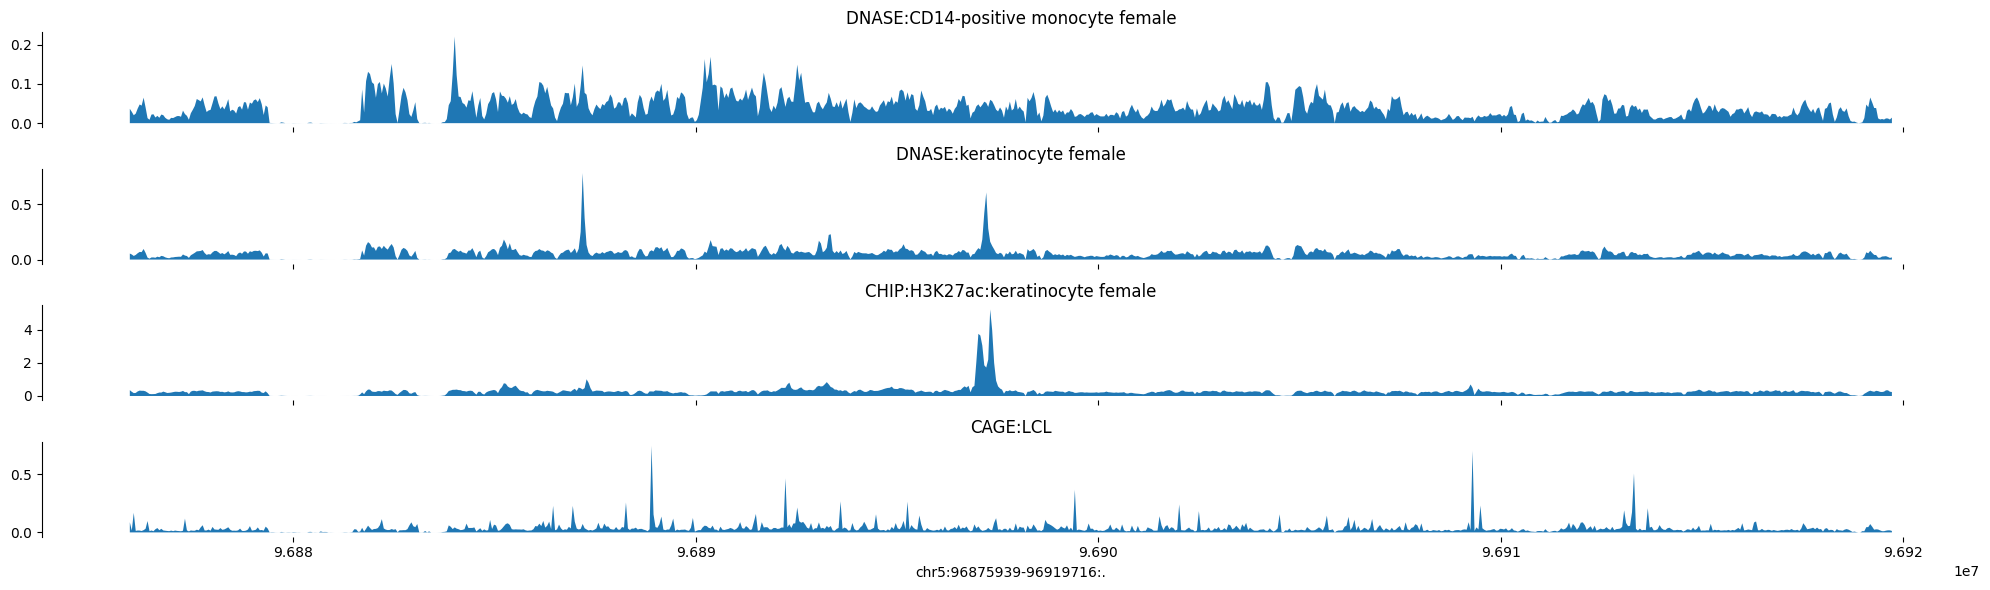

In [8]:
#  Plot Human epigenomes

predictions = pred_human
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:LCL': np.log10(1 + predictions[:, 5110])}
plot_tracks(tracks, target_interval)

### Plot Neanderthal epigenome

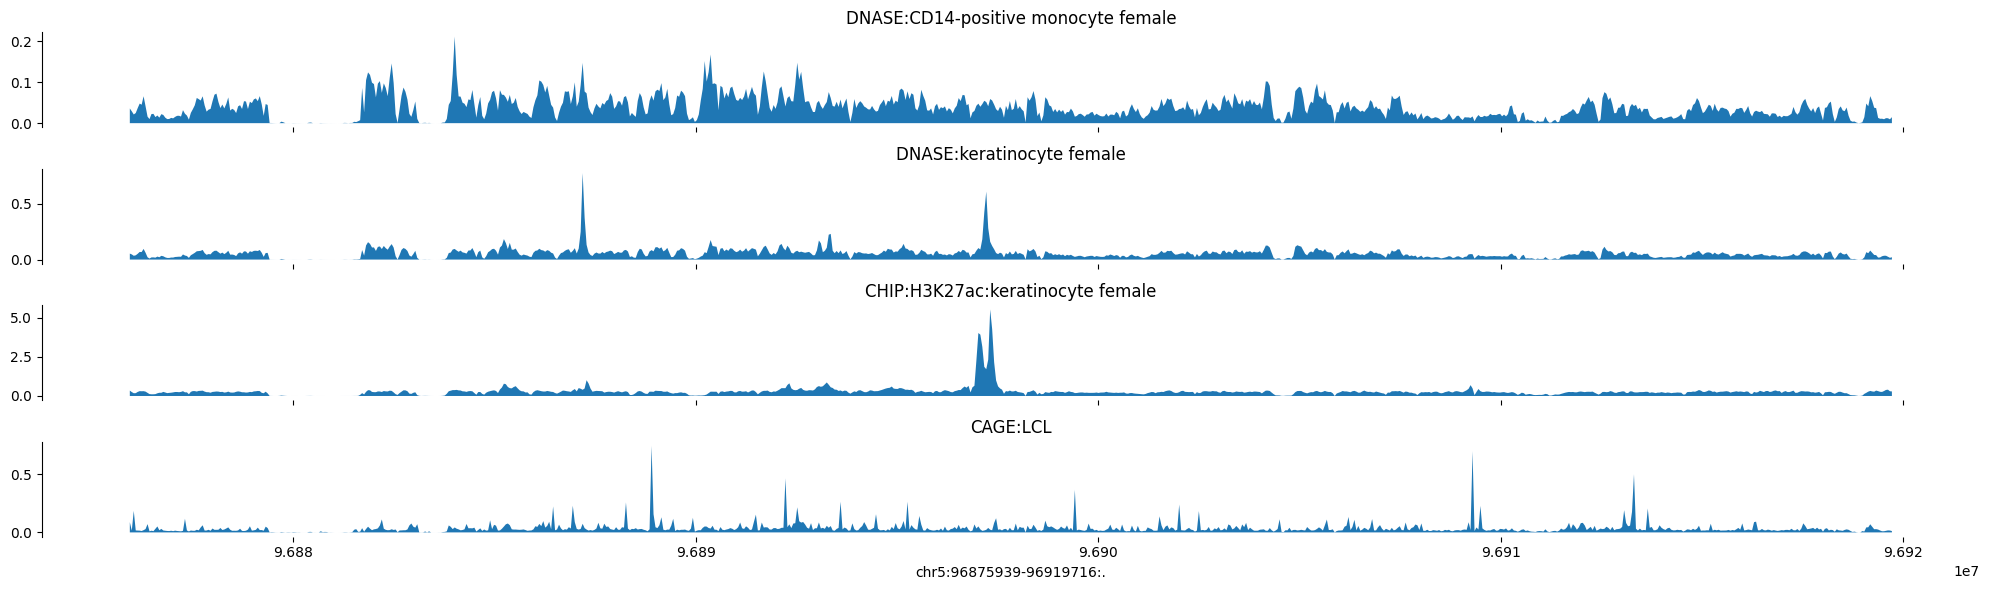

In [9]:
predictions = pred_altai
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:LCL': np.log10(1 + predictions[:, 5110])}
plot_tracks(tracks, target_interval)

In [10]:
get_summary(get_diffmat(pred_human,pred_altai))
get_summary(column_correlations(pred_human,pred_altai))

{'mean': np.float64(0.9963786626060424),
 'median': np.float64(0.9985426207070724),
 'minimum': np.float64(0.8450667250216665),
 'maximum': np.float64(0.9999900682433824),
 'q1': np.float64(0.9971584662782969),
 'q3': np.float64(0.9990126346399585)}

### Create scatter plots comparing human and Neanderthal predictions

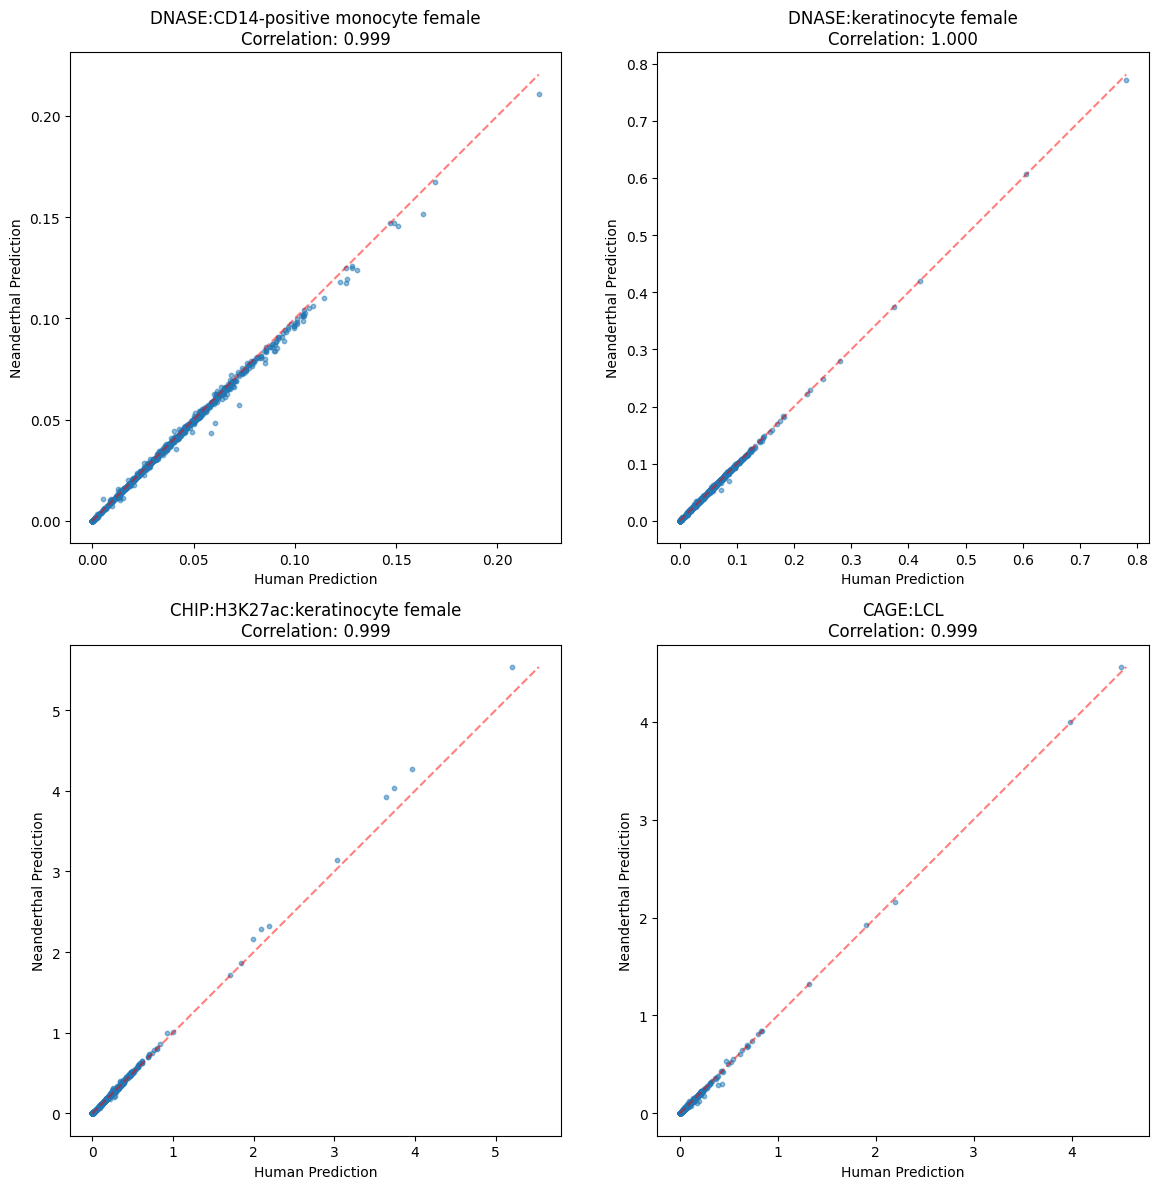

In [11]:
def plot_prediction_scatters(pred_human, pred_altai, tracks):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, (track_name, track_idx) in enumerate(tracks.items()):
        ax = axes[idx]
        
        # Get predictions for this track
        human_pred = pred_human[:, track_idx]
        altai_pred = pred_altai[:, track_idx]
        
        # Create scatter plot
        ax.scatter(human_pred, altai_pred, alpha=0.5, s=10)
        
        # Add diagonal line
        min_val = min(human_pred.min(), altai_pred.min())
        max_val = max(human_pred.max(), altai_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        
        # Calculate correlation
        corr = np.corrcoef(human_pred, altai_pred)[0,1]
        
        # Add labels and title
        ax.set_xlabel('Human Prediction')
        ax.set_ylabel('Neanderthal Prediction')
        ax.set_title(f'{track_name}\nCorrelation: {corr:.3f}')
        
        # Make plot square
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# Define tracks
tracks = {
    'DNASE:CD14-positive monocyte female': 41,
    'DNASE:keratinocyte female': 42,
    'CHIP:H3K27ac:keratinocyte female': 706,
    'CAGE:LCL': 5110
}

# Create the plots
plot_prediction_scatters(pred_human, pred_altai, tracks)
